In [1]:
import numpy as np
import matplotlib.pyplot as plt
import LISA_tools as LISA

In [37]:
"""
Tools...
"""
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

"""
PhenomA coefficeints:
Coefficients from Table 2 in ``LISA Sensitivity'' - Neil Cornish & Travis Robson
"""

a0 = 2.9740e-1
b0 = 4.4810e-2
c0 = 9.5560e-2

a1 = 5.9411e-1
b1 = 8.9794e-2
c1 = 1.9111e-1

a2 = 5.0801e-1
b2 = 7.7515e-2
c2 = 2.2369e-2

a3 = 8.4845e-1
b3 = 1.2848e-1
c3 = 2.7299e-1

""" Constants """
C       = 299792458.         # m/s
YEAR    = 3.15581497632e7    # sec
TSUN    = 4.92549232189886339689643862e-6 # mass of sun in seconds (G=C=1)
MPC     = 3.08568025e22/C    # mega-Parsec in seconds


def get_Sn(constants):
	# constants = np.arrays([H0, Omega_m, L, f_star, Tobs, NC])
	f_star = constants[3]
	L      = constants[2]
	NC     = constants[5]
	Tobs   = constants[4]
	
	transfer_data = np.genfromtxt('R.txt')
	f = transfer_data[:,0]*f_star # convert to frequency
	R = transfer_data[:,1]*NC     # response gets improved by more data channels
	
	Sn = get_Pn(f, f_star, L)/R + get_Sc_est(f, Tobs, NC)
	
	return f, Sn

def get_Sc_est(f, Tobs, NC):
    """
    Get an estimation of the galactic binary confusion noise are available for
        Tobs = {0.5 yr, 1 yr, 2 yr, 4yr}
    Enter Tobs as a year or fraction of a year
    """
    # Fix the parameters of the confusion noise fit
    if (Tobs == 0.5*YEAR):
        est = 1
    elif (Tobs == 1.0*YEAR):
        est = 2
    elif (Tobs == 2.0*YEAR):
        est = 3
    elif (Tobs == 4.0*YEAR):
        est = 4

    # else find the closest observation period estimation
    else:
        if (Tobs < .75*YEAR):
            est = 1
        elif (0.75*YEAR < Tobs and Tobs < 1.5*YEAR):
            est = 2
        elif (1.5*YEAR < Tobs and Tobs < 3.0*YEAR):   
            est = 3
        else:
            est = 4
            
    if (est==1):
        alpha  = 0.133
        beta   = 243.
        kappa  = 482.
        gamma  = 917.
        f_knee = 2.58e-3  
    elif (est==2):
        alpha  = 0.171
        beta   = 292.
        kappa  = 1020.
        gamma  = 1680.
        f_knee = 2.15e-3 
    elif (est==3):
        alpha  = 0.165
        beta   = 299.
        kappa  = 611.
        gamma  = 1340.
        f_knee = 1.73e-3  
    else:
        alpha  = 0.138
        beta   = -221.
        kappa  = 521.
        gamma  = 1680.
        f_knee = 1.13e-3 
    
    A = 1.8e-44/NC
    
    Sc  = 1. + np.tanh(gamma*(f_knee - f))
    Sc *= np.exp(-f**alpha + beta*f*np.sin(kappa*f))
    Sc *= A*f**(-7./3.)
    
    return Sc
    
def get_Pn(f, f_star, L):
    """
    Get the Power Spectral Density
    """
    
    # single-link optical metrology noise (Hz^{-1}), Equation (10)
    P_oms = (1.5e-11)**2*(1. + (2.0e-3/f)**4) 
    
    # single test mass acceleration noise, Equation (11)
    P_acc = (3.0e-15)**2*(1. + (0.4e-3/f)**2)*(1. + (f/(8.0e-3))**4) 
    
    # total noise in Michelson-style LISA data channel, Equation (12)
    Pn = (P_oms + 2.*(1. + np.cos(f/f_star)**2)*P_acc/(2.*np.pi*f)**4)/L**2
    
    return Pn
    
    
def get_Sn_approx(f, f_star, L, NC):
    """
    Get the noise curve approximation, Equation (1) of ``LISA Sensitivity'' - Neil Cornish & Travis Robson
    """
    
    # Sky and polarization averaged signal response of the detector, Equation (9)
    Ra = 3./20./(1. + 6./10.*(f/f_star)**2)*NC
    
    # strain spectral density, Equation (2)
    Sn = get_Pn(f, f_star, L)/Ra
    
    return Sn
    

def get_A(f, M, eta, Mc, Dl):
	"""
	PhenomA: Binary Waveform
	--------------
	Section 2 of ``LISA Sensitivity'' - Neil Cornish & Travis Robson
	"""

	f0 = (a0*eta**2 + b0*eta + c0)/(np.pi*M) # merger frequency
	f1 = (a1*eta**2 + b1*eta + c1)/(np.pi*M) # ringdown frequency
	f2 = (a2*eta**2 + b2*eta + c2)/(np.pi*M) # decay-width of ringdown
	f3 = (a3*eta**2 + b3*eta + c3)/(np.pi*M) # cut-off frequency

	A = np.sqrt(5./24.)*Mc**(5./6.)*f0**(-7./6.)/np.pi**(2./3)/Dl

	if (f < f0):
		A *= (f/f0)**(-7./6.)

	elif (f0 <= f and f < f1):
		A *= (f/f0)**(-2./3.)

	elif (f1 <= f and f < f3):
		w = 0.5*np.pi*f2*(f0/f1)**(2./3.)
		A *= w*f2/((f - f1)**2 + 0.25*f2**2)/(2.*np.pi)
	
	else:
		A *= 0.

	return A

def get_Dl(z, Omega_m, H0):
    """ calculate luminosity distance in geometrized units """
    # see http://arxiv.org/pdf/1111.6396v1.pdf
    x0 = (1. - Omega_m)/Omega_m
    xZ = x0/(1. + z)**3

    Phi0  = (1. + 1.320*x0 + 0.4415*x0**2  + 0.02656*x0**3)
    Phi0 /= (1. + 1.392*x0 + 0.5121*x0**2  + 0.03944*x0**3)
    PhiZ  = (1. + 1.320*xZ + 0.4415*xZ**2  + 0.02656*xZ**3)
    PhiZ /= (1. + 1.392*xZ + 0.5121*xZ**2  + 0.03944*xZ**3)
    
    return 2.*C/H0*(1.0e-3*MPC)*(1. + z)/np.sqrt(Omega_m)*(Phi0 - PhiZ/np.sqrt(1. + z))
   # return 2./H0*(1.0e-3*MPC)*(1. + z)/np.sqrt(Omega_m)*(Phi0 - PhiZ/np.sqrt(1. + z))


def get_z(z, Dl, Omega_m, H0):
    """ calculate redishift uisng root finder """
    return get_Dl(z, Omega_m, H0) - Dl
    
def get_h_char_track(f, f_start, f_end, M, eta, M_chirp, Dl, constants):

	# constants = np.arrays([H0, Omega_m, L, f_star, Tobs, NC])
	f_star = constants[3]
	L      = constants[2]
	NC     = constants[5]
	Tobs   = constants[4]
	
	A_arr   = np.zeros(len(f))
	h_c_arr = np.zeros(len(f))

	arg_start = np.where(f<=f_start)[0][-1]
	if (f_end > 1.): # i.e. off the graph
		arg_end = len(f)-1 #np.len(f)-1
	else:
		arg_end = np.where(f>=f_end)[0][0]

	for i in range(arg_start, arg_end):
		A_arr[i]   = get_A(f[i], M, eta, M_chirp, Dl) 
		h_c_arr[i] = f[i]*A_arr[i]*np.sqrt(16./5.) 
		
		
	SNR = 0.
	f, Sn = get_Sn(constants)
	for i in range(arg_start, arg_end):
		freq   = 0.5*(f[i] + f[i-1])
		Sn_est = 0.5*(1./Sn[i] + 1./Sn[i-1])
		SNR += 16./5.*freq*get_A(freq, M, eta, M_chirp, Dl)**2*Sn_est*(np.log(f[i]) - np.log(f[i-1]))
	SNR = np.sqrt(SNR)

	return h_c_arr, SNR
    
    
def get_h_char_point(f_start, f_end, M, eta, M_chirp, Dl, constants):

	# constants = np.arrays([H0, Omega_m, L, f_star, Tobs, NC])
	f_star = constants[3]
	L      = constants[2]
	NC     = constants[5]
	Tobs   = constants[4]
	
	h_c = np.sqrt(16./5.*(f_end-f_start)*f_start)*get_A(f_start, M, eta, M_chirp, Dl)

	Sn_est = get_Sn_approx(f_start, f_star, L, NC) + get_Sc_est(f_start, Tobs, NC)
	SNR = 8.*np.sqrt(Tobs/5.)*M_chirp**(5./3.)*(np.pi*f_start)**(2./3.)/Dl/np.sqrt(Sn_est)
        
	return h_c, SNR
    
"""
Calculate the Characteristic strain of the source

Inputs:
    m1 - component mass 1, SOURCE FRAME!
    m2 - component mass 2, SOURCE FRAME!
    
    Initial condition options (Specify one!)
    --------------------------
    T_merger - time to merger for source
    f_start  - start frequency for source
    
    Distance options (Specify one!)
    --------------------------
    D_lum - Luminosity distance
    z     - redshift
"""

def calculate_plot_source(m1, m2, constants, Dl=None, z=None, T_merger=None, f_start=None):
	"""
	Determine the appropriate way to plot the source, calculate its characteristic strain
	and print the correpsonding SNR.
	"""
	# constants = np.arrays([H0, Omega_m, L, f_star, Tobs, NC])
	Omega_m = constants[1]
	H0      = constants[0]
	Tobs    = constants[4]
	NC      = constants[5]
	L       = constants[2]
	f_star  = constants[3]

	f, Sn = get_Sn(constants)

	""" Sort out the luminosity distance and redshift of the source """
	if (Dl==None): # Z was specified, then we must calculate Dl
		Dl = get_Dl(z, Omega_m, H0)
	elif(z==None):
		z = optimize.root(get_z, 1., args=(Dl, Omega_m, H0)).x[0]

	""" Calculate relevant mass parameters """
	m1 *= (1. + z) # redshift the source frame masses
	m2 *= (1. + z)
	M = m1 + m2                           # total mass
	M_chirp = (m1*m2)**(3./5.)/M**(1./5.) # chirp mass
	eta = (m1*m2)/M**2                    # symmetric mass ratio   

	""" Calculate PhenomA cut-off frequency """
	f3 = (a3*eta**2 + b3*eta + c3)/(np.pi*M) 

	if (f_start==None): # T_merger was specified
		f_start = (5.*M_chirp/T_merger)**(3./8.)/(8.*np.pi*M_chirp)
	else: # f_start was specified, calculate time to merger for circular binary
		T_merger = 5.*M_chirp/(8.*np.pi*f_start*M_chirp)**(8./3.)

	""" Determine the ending frequency of this source """
	if (T_merger > Tobs):
		f_end = (5.*M_chirp/(np.abs(Tobs-T_merger)))**(3./8.)/(8.*np.pi*M_chirp)
	elif (T_merger <= Tobs):
		f_end = f3

	""" Plot the results """
	plt.figure(figsize=(8,6))
	plt.rcParams['text.usetex'] = False
	plt.ion()
	plt.rc('text', usetex=False)
	plt.rc('font', family='Times')
	plt.xlabel(r'$f ~[Hz]$', fontsize=20, labelpad=10)
	plt.ylabel(r'Characteristic Strain', fontsize=20, labelpad=10)
	plt.tick_params(axis='both', which='major', labelsize=20)

	# How much log bandwidth does the source span
	d_log_f = np.log(f_end/f_start)

	if (d_log_f > 0.5): # plot a track
		h_c_arr, SNR = get_h_char_track(f, f_start, f_end, M, eta, M_chirp, Dl, constants)

		plt.loglog(f, h_c_arr) 
		title = 'Track SNR: ' + str(SNR)
		plt.title(title, fontsize=20)

		out_file = 'char_signal_strain.dat'
		np.savetxt(out_file,(np.vstack((f, h_c_arr)).T), delimiter=' ')

	else: # track is too short, plot a point
		h_c, SNR = get_h_char_point(f_start, f_end, M, eta, M_chirp, Dl, constants)

		plt.loglog(f_start, h_c, 'r.')
		title = 'Point SNR: ' + str(SNR)
		plt.title(title, fontsize=20)

		out_file = 'char_signal_strain.dat'
		np.savetxt(out_file,(np.vstack((f_start, h_c)).T), delimiter=' ')

	plt.loglog(f, np.sqrt(f*Sn)) # plot the characteristic strain of noise
	%config InlineBackend.figure_format = 'retina'
	plt.xlim(1.0e-5, 1.0e0)
	plt.ylim(1.0e-22, 1.0e-15)
	plt.tight_layout()
	plt.tick_params(labelsize=20)

	plt.show()

	return None
    
    
    
    
    
    

In [2]:
""" Cosmological values """
H0 = 69.6 # Hubble parameter today
Omega_m = 0.286 # density parameter of matter
""" LISA arm length """
L = 2.5e9 # meters
""" Transfer Frequency """
f_star = LISA.C/(2.*np.pi*L)
""" Observation Period """
Tobs = 4.*LISA.YEAR
""" Number of Michelson Data Channels """
NC = 2
constants = np.array([H0, Omega_m, L, f_star, Tobs, NC])

In [3]:
f, Sn = LISA.get_Sn(constants)

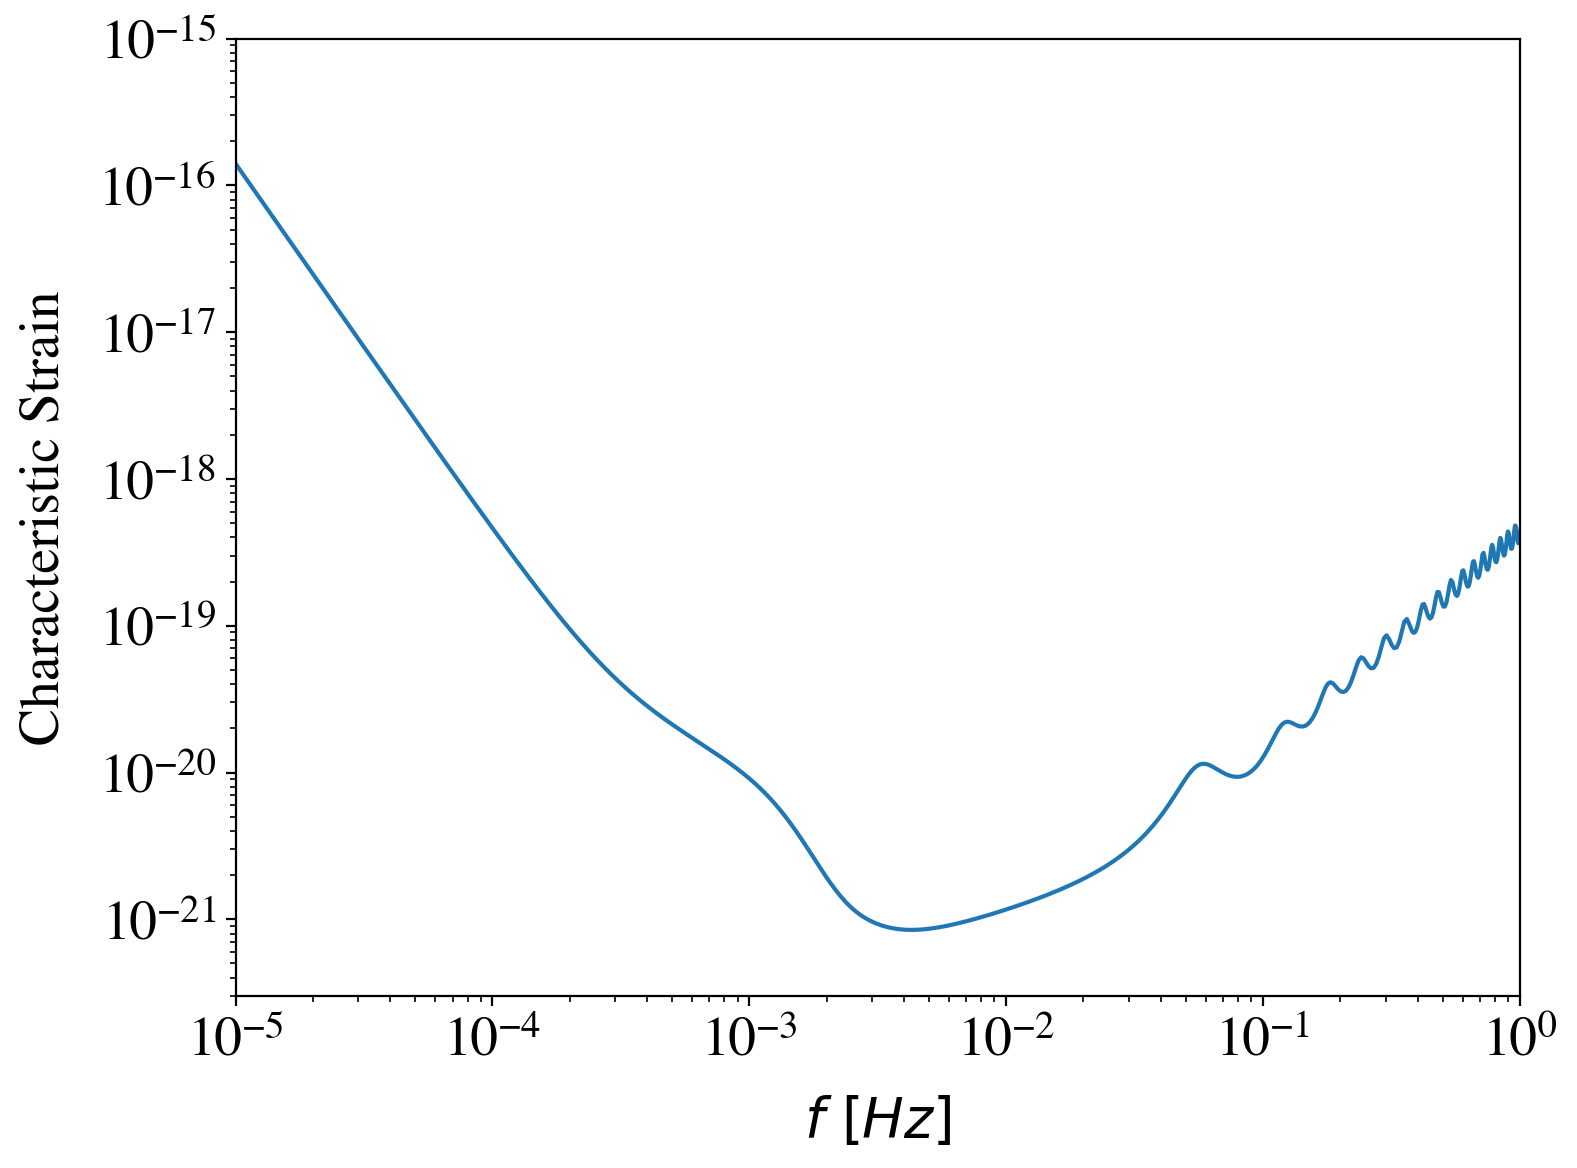

In [25]:
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(8,6))
plt.rc('font', family='Times')
plt.xlabel(r'$f ~[Hz]$', fontsize=20, labelpad=10)
plt.ylabel(r'Characteristic Strain', fontsize=20, labelpad=10)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.loglog(f, np.sqrt(f*Sn)) # plot the characteristic strain
plt.xlim(1.0e-5, 1.0e0)
plt.ylim(3.0e-22, 1.0e-15)
plt.tight_layout()
plt.tick_params(labelsize=20)
plt.show()
out_file = 'characteristic_noise_strain.dat'
np.savetxt(out_file,(np.vstack((f, np.sqrt(f*Sn))).T), delimiter=' ')

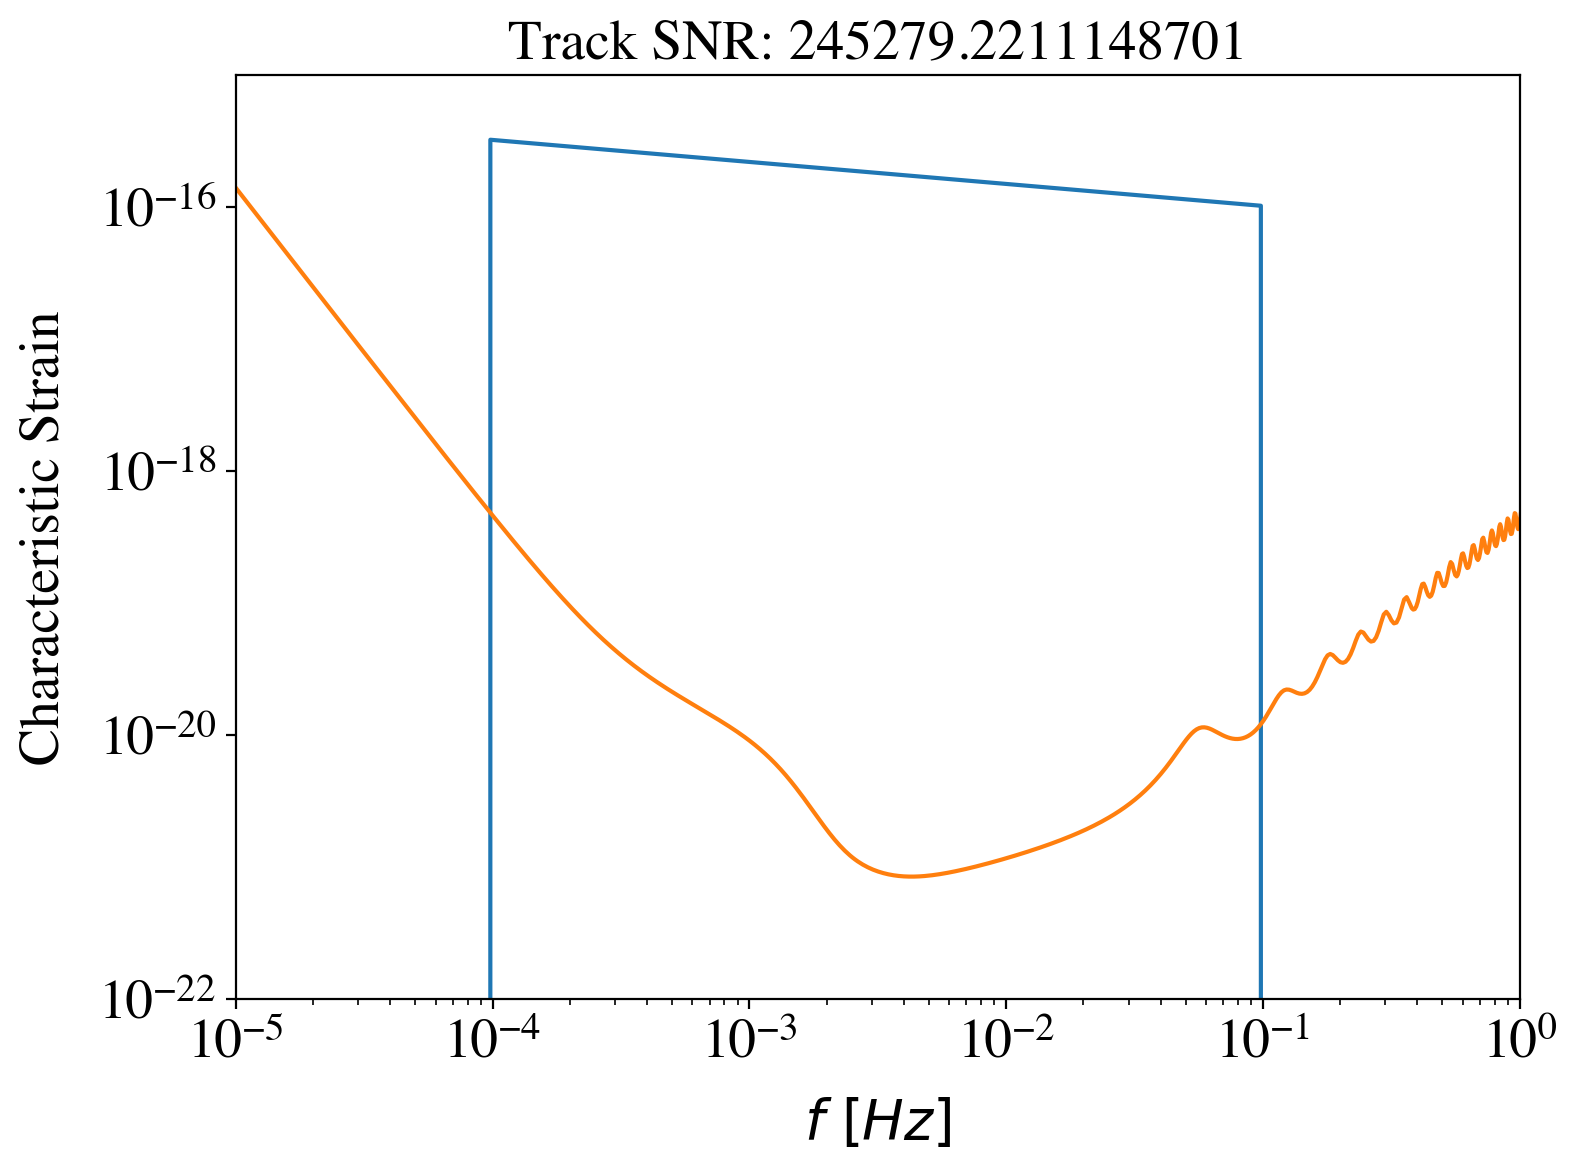

In [41]:
m1 = 0.50*LISA.TSUN # leading coefficient is the
m2 = 0.50*LISA.TSUN # mass in terms of solar mass
D_lum = 1.e-3*LISA.MPC # Luminosity Distance, meters
z = None # Redshift
T_merger = 5 # time to merger
f_start = 1e-4#2.6e-3 # start frequency


# m1 = 0.5e6*LISA.TSUN # leading coefficient is the
# m2 = 0.5e6*LISA.TSUN # mass in terms of solar mass
# D_lum = None # Luminosity Distance, meters
# z = 3. # Redshift
# T_merger = 1.*LISA.YEAR # time to merger
# f_start = None # start frequency

calculate_plot_source(m1, m2, constants, Dl=D_lum, z=z, T_merger=T_merger, f_start=f_start)

In [ ]:


get_h_char_track(f, f_start, f_end, M, eta, M_chirp, Dl, constants)

# LISA Curves

In [110]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as  pd
import scipy.special as sp
import os
import math


pi = math.pi
k2=4.*pi*pi
pctoau=206264.806
pcToAU=206264.806
c2 =3.993953869e9
auPyrTokmPsec=4.74 # au/yr -> km /sec
kmPsecToauPyr=1./auPyrTokmPsec
kmToAU=6.68459e-9
secToyr=3.17e-8
yr2sec = 3.154e7
c2AUyr=3.993953869e9

mHz=1./1000.
fStar=19.09*mHz ## Hz
L=2.5e9 ## m
Dl=200*pcToAU
m2l = k2/(c2AUyr)


In [352]:
data = np.loadtxt('/Users/bijan1339/Desktop/Rdata.txt', unpack=True)
data = np.loadtxt('R.txt', unpack=True)
fLISA= np.array(data[0,:])
R= np.array(data[1,:])
fLISA=fLISA*fStar
fLISAlog10=np.log10(fLISA)
Rlog10=np.log10(R)

POMS=(1.5e-11)**2 *(1.+(2*mHz/fLISA )**4. )  # 1/Hz
Pacc=(3.e-15)**2 *(1.+(0.4*mHz/fLISA)**2.)*(1.+(fLISA/8/mHz)**4.) #1/Hz

Pn=POMS/L**2.+2*(1.+ np.cos(fLISA/fStar)**2.)* Pacc/( (2*pi*fLISA)**4. *L**2.)


alpha=0.133
beta=243.
kappa=482.
gammav=917. 
fk=0.00258
A_noise = 9.0e-45

tanhf=(1.-np.exp(-2*gammav*(fk-fLISA))) / ( 1. + np.exp(-2*gammav*(fk-fLISA)))

Sc= A_noise*fLISA**(-7/3)*np.exp(-fLISA**alpha+beta*fLISA*np.sin(kappa*fLISA)) *(1.+tanhf) ## 1/Hz

#Equation (13) in Cornish & Robson 2018, has no confusion noise added to it yet
#S_n_fit has units of Hz^-1
#Input f in Hz
Sn=Pn/R
Stot=Pn/R+Sc
hctotLISA=np.sqrt((np.sqrt(Stot*Stot)*fLISA))
hctotLISAlog10=np.log10(np.abs(hctotLISA))

def get_LISA_stuff(m1,m2,a,e, Tobsyr=10):
    # Tobsyr = 10. #yr
    # m2=0.5
    # m1=0.5

    # a=0.01 
    # e=0.8
    Dl = 1.e-3*LISA.MPC
    Tobs = Tobsyr*yr2sec

    P = np.sqrt((a**3)/(m1 + m2)) * yr2sec
    f_orb = 1.0/P/(2*np.pi)

    nmin = 1
    fmax = 1# Hz
    nmax = np.floor(fmax/f_orb)
    n=10**(np.linspace(np.log10(nmin),np.log10(nmax),num=64))  #(log10(nmin)0.1log10(nmax))
    fn = f_orb*n   
    ne = n*e

    gn=((n**4)/32) *( (sp.jv(n-2.,ne) - 2*e*sp.jv(n-1.,ne) + 2*sp.jv(n,ne)/n+ 2*e*sp.jv(n+1.,ne) - sp.jv(n+2.,ne) )**2 + \
        (1-e**2)*(sp.jv(n-2.,ne) -2* sp.jv(n,ne) + sp.jv(n+2.,ne))**2 +4*sp.jv(n,ne)**2/3/(n**2) ) 
    h0 = np.sqrt(32.0/5.0)*(m1*m2l)*(m2*m2l)/(Dl*a)
        
    hn=2*np.sqrt(gn)*h0/n

    htot=hn
    strain=2*fn*Tobs*np.sqrt(htot**2)

    #### Calcualte the SNR
    #interpolating the strain for the LISA curve
    strainInterp=10**(np.interp(np.log10(fn),np.log10(fLISA),np.log10(Stot)))

    Inotnan=np.where(~np.isnan(strainInterp))
    ress=np.trapz(gn[Inotnan]/n[Inotnan]/n[Inotnan]/strainInterp[Inotnan],n[Inotnan])
    Fe = (1.0 - e*e)**(-7.0/2.0)*(1.0 + (73.0/24.0)*e*e + (37.0/96.0)*e**4)
    fdfdot = (5.0/96.0)*np.sqrt(c2)**5.0*a**4.0/((k2**3.0)*m1*m2*(m1 + m2)*Fe)*yr2sec

    snr = (2.0/np.sqrt(5))*4.0*h0*np.sqrt(0.885895*Tobs*ress)*np.min([1.0,np.sqrt(fdfdot/Tobs)])

    return (fn, strain, snr)

/var/folders/l6/fs0wwf710258x1tr4jxfgbw40000gn/T/ipykernel_73765/1057535334.py:22: RuntimeWarning: overflow encountered in exp
  tanhf=(1.-np.exp(-2*gammav*(fk-fLISA))) / ( 1. + np.exp(-2*gammav*(fk-fLISA)))
/var/folders/l6/fs0wwf710258x1tr4jxfgbw40000gn/T/ipykernel_73765/1057535334.py:22: RuntimeWarning: invalid value encountered in divide
  tanhf=(1.-np.exp(-2*gammav*(fk-fLISA))) / ( 1. + np.exp(-2*gammav*(fk-fLISA)))


In [171]:
def get_fpeak(m1,m2,a,e):
    P = np.sqrt((a**3)/(m1 + m2)) * yr2sec
    f_orb = 1.0/(P)
    
    return (f_orb * (np.power(1+e,1/2) / np.power(1-e,3/2) ))

In [185]:
df = all_WDWDs.sort_values('a1').query("a1<0.01")

(1e-05, 0.3981071705534972)

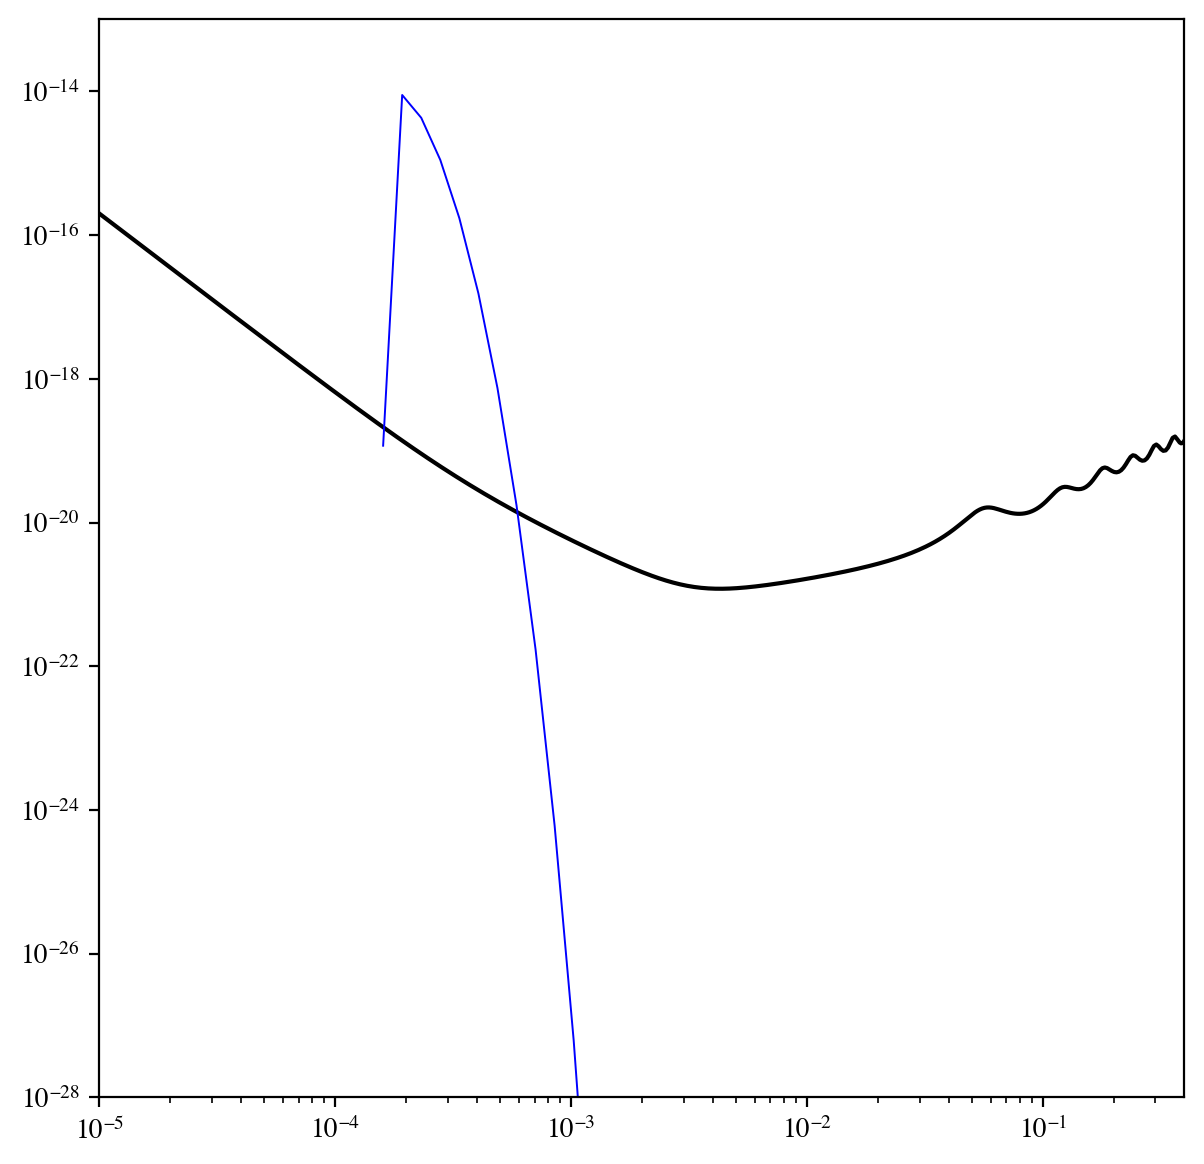

In [192]:
fig, ax = plt.subplots(figsize=(7,7))
ax.loglog(f, np.sqrt(f*Sn),color='black') 

this_fn, this_strain, this_snr = get_LISA_stuff(m1 = 0.5, m2 = 0.5, a = 1e-3, e = 0.001, Tobsyr=10) 
ax.loglog(this_fn, this_strain, lw=0.7,color='b')

ax.set_ylim(1e-28,1e-13)
ax.set_xlim(1e-5,10**(-0.4))

In [251]:
WD_dict = df[['m1', 'm2', 'a1', 'e1']].to_dict('records')
WD_arr = np.column_stack((m1,m2,a1,e1))

#change all e=0 to 1e-7
mask = (WD_arr[:, 3] <= 0)
WD_arr[mask, 3] = 1e-7

WD_arr[0:5]


array([[ 5.60787900e+00,  6.84447000e+00, -4.65047000e-03,
         1.00000000e-07],
       [ 4.28034900e+00,  7.06014600e+00, -4.65047000e-03,
         1.00000000e-07],
       [ 6.10675500e+00,  7.16569400e+00, -4.65047000e-03,
         1.00000000e-07],
       [ 6.68157200e+00,  6.25843000e+00, -4.65047000e-03,
         1.00000000e-07],
       [ 7.62016900e+00,  2.66459900e+00,  8.83040946e-11,
         1.00000000e-05]])

In [447]:
%%capture
fns=[]
strains=[]
snrs=[]
peaks=[]
cmap = plt.cm.get_cmap('Spectral')
df = all_WDWDs#.query('a1<1e-2')
df.loc[df['e1'] <= 0, 'e1'] = 1e-5

for i, row in df.iterrows():

    
    this_m1, this_m2, this_a, this_e = row['m1'], row['m2'], np.abs(row['a1']), row['e1']
    try:
        this_fn, this_strain, this_snr = get_LISA_stuff(m1 = this_m1, m2 = this_m2, a = this_a, e = this_e, Tobsyr=4) 
        this_fpeak = get_fpeak(this_m1, this_m2, this_a, this_e)
    except: continue
    
    fns    .append(this_fn)
    strains.append(this_strain)
    peaks  .append(this_fpeak)
    snrs   .append(this_snr)
    
    df.loc[i,'SNR']  = this_snr
    df.loc[i,'peak'] = this_fpeak
    
fns, strains, peaks, snrs = np.array(fns), np.array(strains), np.array(peaks), np.array(snrs)
max_SNR = np.max(snrs[~np.isnan(snrs)])
my_snrs = snrs[~np.isnan(snrs)]


In [446]:
np.mean(my_snrs)

19.941208548315714

(1e-05, 0.3981071705534972)

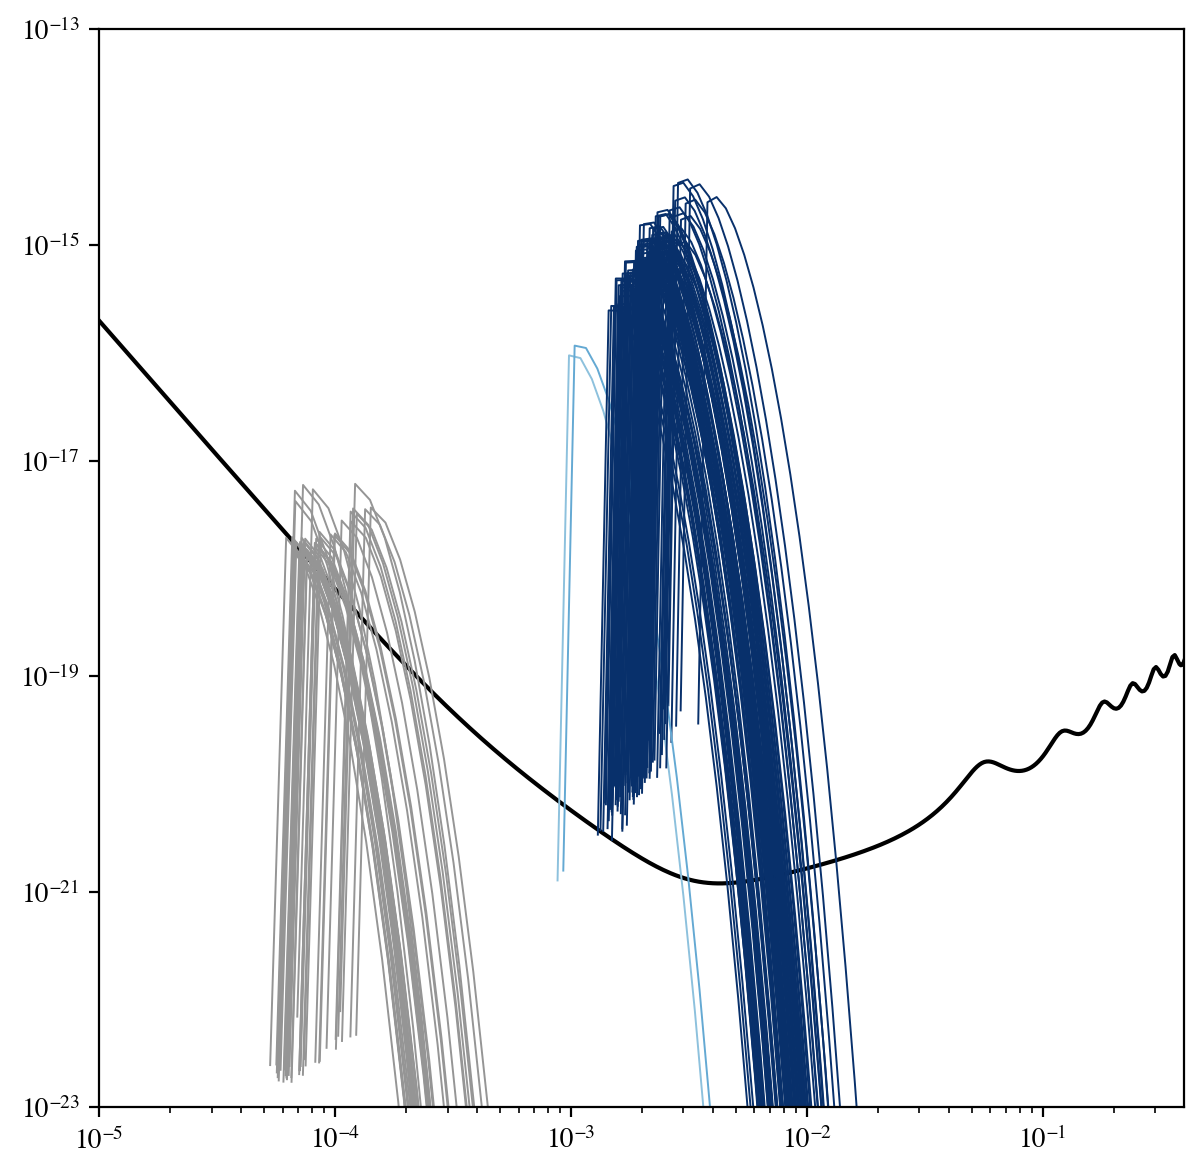

In [448]:
%%capture --no-display

fig, ax = plt.subplots(figsize=(7,7))
ax.loglog(f, np.sqrt(f*Sn),color='black') #LISA Strain

cmap = plt.cm.get_cmap('Blues')
colors=[]
for i, row in df.iterrows():    
    this_m1, this_m2, this_a, this_e = row['m1'], row['m2'], np.abs(row['a1']), row['e1']
    try:
        this_fn, this_strain, this_snr = get_LISA_stuff(m1 = this_m1, m2 = this_m2, a = this_a, e = this_e, Tobsyr=4) 
        this_fpeak = get_fpeak(this_m1, this_m2, this_a, this_e)
    except: continue
    
    color = cmap(this_snr / 25)
    if this_snr <=5:
        color = plt.cm.get_cmap('Greys')(0.5)
        colors.append(colors)
    if this_snr>=0.004:
        ax.loglog(this_fn, this_strain, lw=0.7,color=color)
    
ax.set_ylim(1e-23,1e-13)
ax.set_xlim(1e-5,10**(-0.4))


In [442]:
len(df.query("SNR>=5"))
# Email Erez to see if he wants to be in the Co-author or if just to be put in the acknolwedgements
#talk about importance of mass loss to create a distribution that matches to GAIA
#Send Figure 2 to an appendix, in which you discuss why what is happenning in the figure and such.
    #This appendix will be discussing the patterns seen in the parameters, but keep the time-evolution plot
#Should I have Gaia Comparisons be its own section; change the subsection titles
#Re-order numerical stup, introduce exactly what was done in an order that will make it reproducible
#Email Brad to meet on the 2nd

926

/var/folders/l6/fs0wwf710258x1tr4jxfgbw40000gn/T/ipykernel_73765/2812761985.py:49: RuntimeWarning: divide by zero encountered in double_scalars
  nmax = np.floor(fmax/f_orb)
/var/folders/l6/fs0wwf710258x1tr4jxfgbw40000gn/T/ipykernel_73765/2812761985.py:51: RuntimeWarning: invalid value encountered in multiply
  fn = f_orb*n
/var/folders/l6/fs0wwf710258x1tr4jxfgbw40000gn/T/ipykernel_73765/2812761985.py:50: RuntimeWarning: divide by zero encountered in log10
  n=10**(np.linspace(np.log10(nmin),np.log10(nmax),num=48))  #(log10(nmin)0.1log10(nmax))
/var/folders/l6/fs0wwf710258x1tr4jxfgbw40000gn/T/ipykernel_73765/2812761985.py:54: RuntimeWarning: divide by zero encountered in divide
  gn=((n**4)/32) *( (sp.jv(n-2.,ne) - 2*e*sp.jv(n-1.,ne) + 2*sp.jv(n,ne)/n+ 2*e*sp.jv(n+1.,ne) - sp.jv(n+2.,ne) )**2 + \
/var/folders/l6/fs0wwf710258x1tr4jxfgbw40000gn/T/ipykernel_73765/2812761985.py:55: RuntimeWarning: divide by zero encountered in divide
  (1-e**2)*(sp.jv(n-2.,ne) -2* sp.jv(n,ne) + sp.jv(n+2.,

(1e-08, 0.3981071705534972)

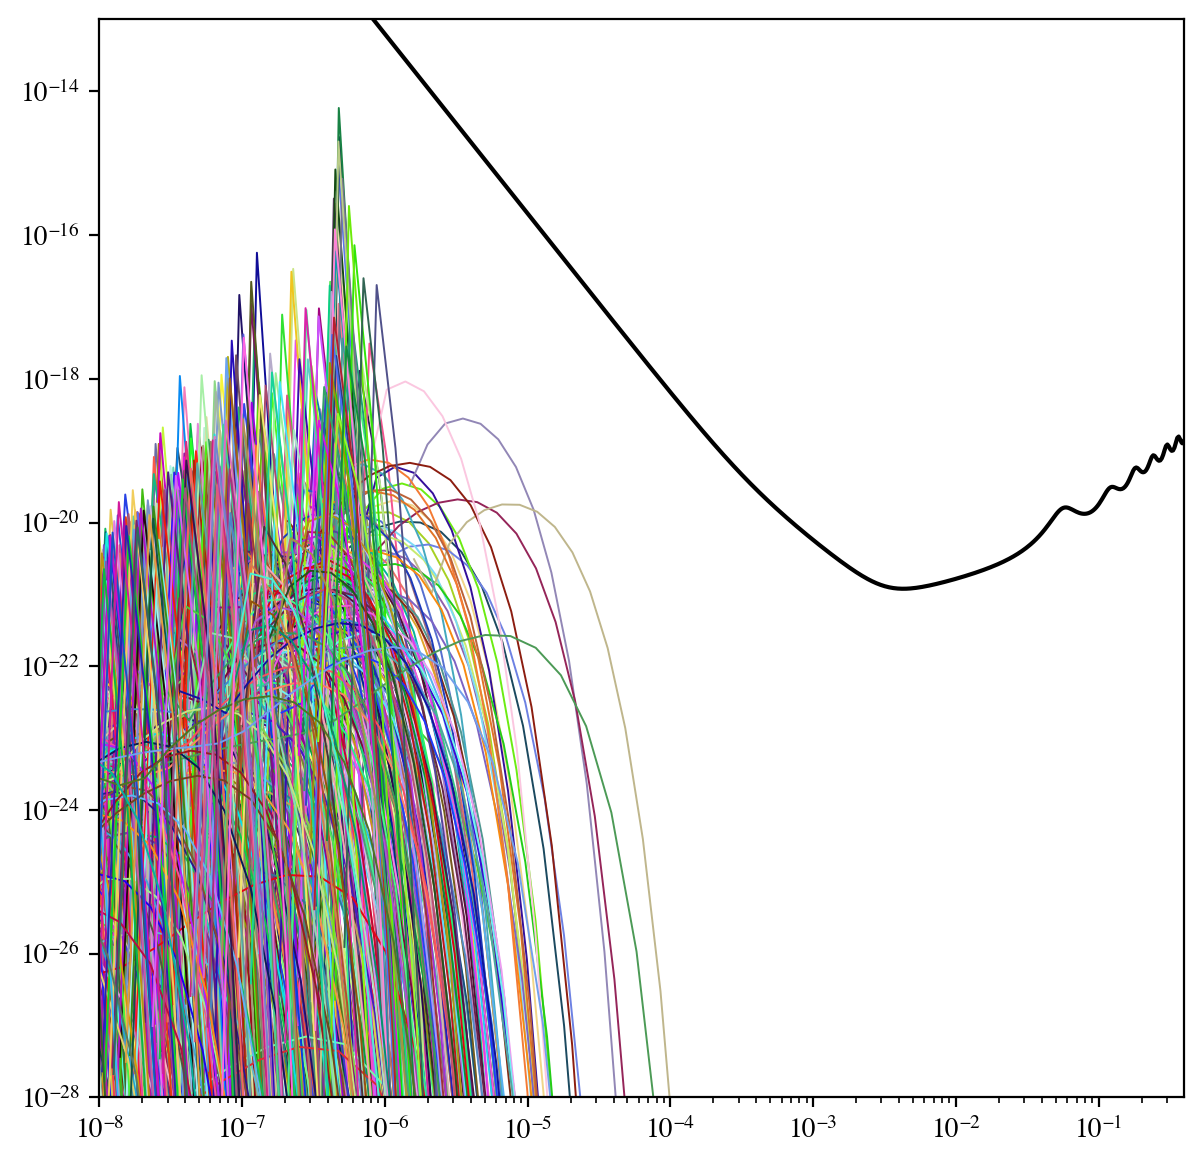

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
ax.loglog(f, np.sqrt(f*Sn),color='black') #LISA Strain
snrs=[]
peaks=[]
for i, row in all_WDWDs.iterrows():
    c=np.random.rand(3,)
    
    this_m1, this_m2, this_a, this_e = row['m1'], row['m2'], row['a1'], row['e1']
    try:
        this_fn, this_strain, this_snr = get_LISA_stuff(m1 = this_m1, m2 = this_m2, a = this_a, e = this_e, Tobsyr=10) 
        this_fpeak = get_fpeak(this_m1, this_m2, this_a, this_e)
    except: continue
    if this_fpeak < 1e-8: continue
    peaks.append(this_fpeak)
    snrs.append(this_snr)
    ax.loglog(this_fn, this_strain, lw=0.7,color=c)

ax.set_ylim(1e-28,1e-13)
ax.set_xlim(1e-8,10**(-0.4))
    

In [161]:
get_fpeak(0.5, 0.5, 1e-3,0.9)

0.04370338856084408

(array([107.,  53.,   8.,  49., 121., 194., 225.,  96.,  24.,   4.]),
 array([-3.67381157, -2.81483801, -1.95586446, -1.09689091, -0.23791736,
         0.62105619,  1.48002975,  2.3390033 ,  3.19797685,  4.0569504 ,
         4.91592395]),
 <BarContainer object of 10 artists>)

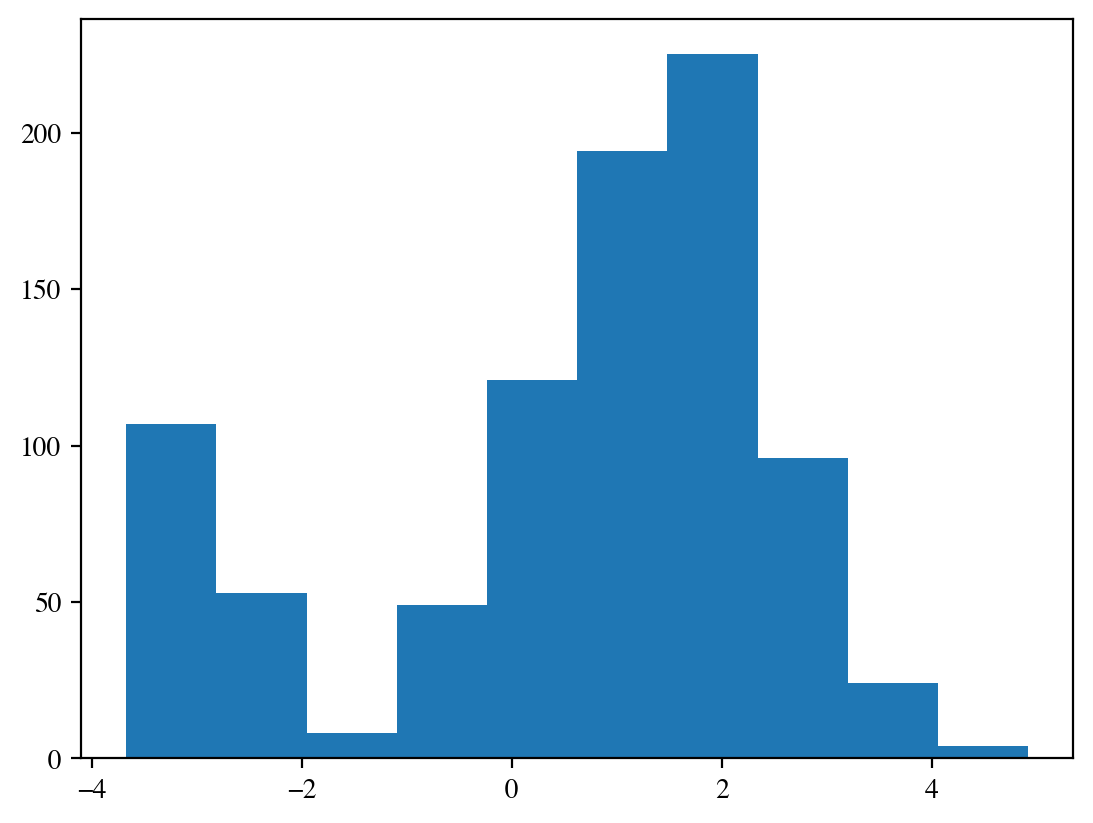

In [155]:
snrs = np.array(snrs)
plt.hist(np.log10(all_WDWDs.a1*(1-all_WDWDs.e1)))

In [375]:
all_finals = pd.read_pickle("/Users/bijan1339/Desktop/Research/Dataframes/all_finals.pkl")
all_OGs = pd.read_pickle("/Users/bijan1339/Desktop/Research/Dataframes/all_OGs.pkl")
all_WDWDs    = all_finals[all_finals['bintype']=='WDWD']
all_WDWDs_OG = all_OGs[all_OGs['bintype']=='WDWD']

In [79]:
import pandas as pd
pd.set_option('display.max_columns', None)


In [83]:
all_WDWDs.query("merged==False").sort_values('m1').tail()

,N,sur,sur2,t,e1,e2,g1,g2,a1,i1,i2,i,spin1h,spintot,beta,vp,spin1e,spin1q,spin2e,spin2q,spin2h,htot,m1,R1,m2,R2,a2,m3,Roche1,R1_pow,type1,type2,type3,beta2,gamma,gamma2,flag,P_in,P_out,startype1,startype2,startype3,bintype,triptype,merged,t_quad
71,6072,3,2,1.253547e+10,0.000000,0.220461,1.338574,1.761647,0.003596,79.92503,8.778834,88.70386,0.761965,7.619646e-01,0.000169,0.0,0.000002,-0.000001,-34.287830,-377.765600,3445.897000,42.47040,3.751752,0.000033,2.372621,0.000321,10778.784716,0.5394,3.531857,1.312001,11,11,0,6.281732,6.616987,45.679542,END,0.075422,3.200445e+08,WD,WD,MS,WDWD,WDWD-MS,False,2.379199e+11
477,1477,3,2,5.948531e+09,0.000021,0.571466,2.438475,-2.317154,62.926435,10.24183,3.803715,14.04555,0.171888,1.718884e-01,0.041837,0.0,0.000030,-0.000122,-295.901100,-116.174200,3093.577000,69.62136,4.426909,0.000042,1.862399,0.000060,4887.824633,0.5283,9.730939,3.461746,11,11,0,5.867007,77.257469,88.256707,CRESTART,148827.340977,8.758706e+07,WD,WD,MS,WDWD,WDWD-MS,False,5.819755e+09
208,6213,3,2,1.254569e+10,0.000000,1.312384,-1.120949,1.788490,56.721458,51.42620,8.722714,NaN,-3042.121000,5.296501e-311,173.399700,0.0,275.911000,218.582300,-0.000342,0.000271,0.186184,108.14350,5.149500,0.000025,6.261833,0.000025,28294.265097,1.3218,0.035152,0.013244,12,11,11,0.134465,74.895479,166.310070,END,100659.472217,NaN,WD,WD,WD,WDWD,WDWD-WD,False,1.201492e+11
343,6350,3,2,1.255481e+10,0.000000,2.876285,-1.352472,-0.598236,19.259695,123.37800,9.460567,132.83860,0.350687,3.506874e-01,0.026379,0.0,-0.000114,0.000115,-14.204250,-2.194620,715.921400,58.30869,5.729259,0.000032,1.049621,0.000065,142108.922813,0.5277,7.753518,2.361865,11,11,0,1.150111,20.354428,42.026149,END,24230.932206,NaN,WD,WD,MS,WDWD,WDWD-MS,False,2.400122e+12
247,1247,3,2,1.253663e+10,0.000000,0.441681,2.050481,-2.018864,0.003432,119.23850,9.017804,128.25630,0.946413,9.464134e-01,0.008687,0.0,0.000143,-0.000009,-213.979300,732.619000,-330.436600,45.59275,6.467674,0.000012,1.133000,0.000304,1886.551605,0.8197,4.167376,1.256334,12,10,1,113.410000,115.386558,166.966420,END,0.063581,2.038644e+07,WD,WD,MS,WDWD,WDWD-MS,False,9.300181e+08


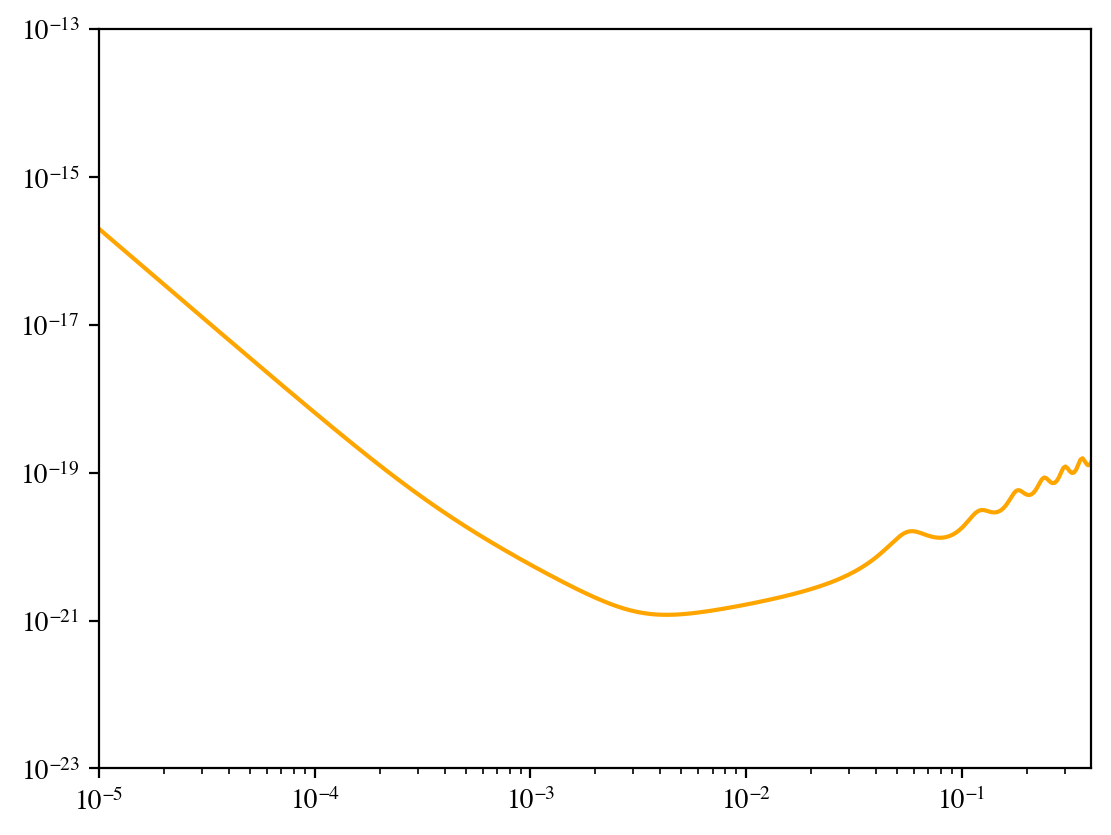

In [89]:
m1, m2, a, e = 2.187359, 1.6132, 0.0002983977834122747, 0.0
fn, strain, snr = get_LISA_stuff(m1 =m1 ,m2 =m2 ,a =a ,e =e , Tobsyr=4) 

#plt.loglog(fLISA,hctotLISA,color='black')
plt.loglog(f, np.sqrt(f*Sn),color='orange')
plt.loglog(fn, strain,color='tab:blue')
#print('strain=',strain)
#print('fn=',fn)
plt.ylim(1e-23,1e-13)
plt.xlim(1e-5,10**(-0.4))
plt.show()

(array([ 16.,  25.,  67.,  90., 141., 162., 133.,  60.,  15.,   6.]),
 array([-1.5520563 , -0.89857602, -0.24509575,  0.40838452,  1.0618648 ,
         1.71534507,  2.36882534,  3.02230562,  3.67578589,  4.32926616,
         4.98274643]),
 <BarContainer object of 10 artists>)

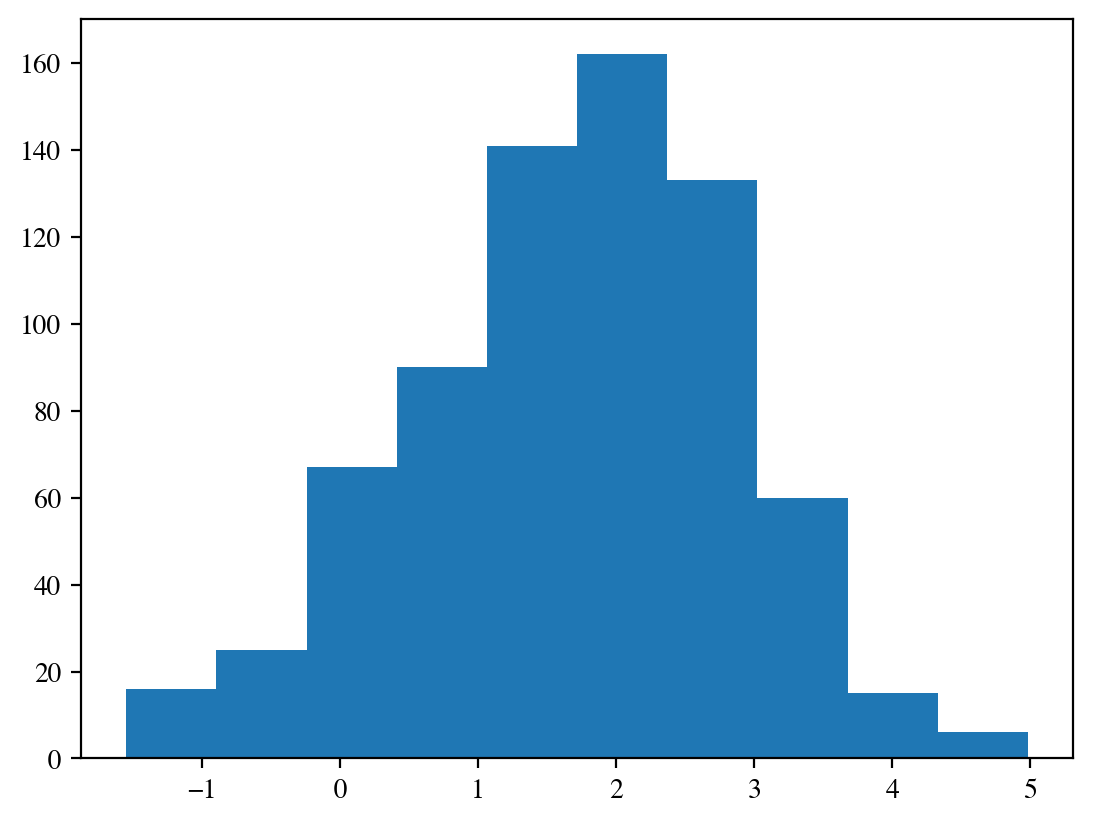

In [95]:
plt.hist(np.log10(all_WDWDs_OG.a1))

In [419]:
# Importing Packages
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# CR3BP Model
def model_CR3BP(state, t):
    x = state[0]
    y = state[1]
    z = state[2]
    x_dot = state[3]
    y_dot = state[4]
    z_dot = state[5]
    x_ddot = x+2*y_dot-((1-mu)*(x+mu))/((x+mu)**2+y**2+z**2)**(3/2) -(mu*(x-(1-mu)))/((x-(1-mu))**2+y**2+z**2)**(3/2)
    y_ddot = y-2*x_dot-((1-mu)*y)/((x+mu)**2+y**2+z**2)**(3/2) -(mu*y)/((x-(1-mu))**2+y**2+z**2)**(3/2)
    z_ddot = -((1-mu)*z)/((x+mu)**2+y**2+z**2)**(3/2) -(mu*z)/((x-(1-mu))**2+y**2+z**2)**(3/2)
    dstate_dt = [x_dot, y_dot, z_dot, x_ddot, y_ddot, z_ddot]
    return dstate_dt
# Defining ND Parameters
G = 6.67408E-20  # Univ. Gravitational Constant [km3 kg-1 s-2]
mEarth = 5.97219E+24  # Mass of the Earth [kg]
mMoon = 7.34767E+22  # Mass of the Moon [kg]
a = 3.844E+5  # Semi-major axis of Earth and Moon [km]
m1 = mEarth
m2 = mMoon
Mstar = m1+m2  # ND Mass Parameter
Lstar = a  # ND Length Parameter
Tstar = (Lstar**3/(G*Mstar))**(1/2)  # ND Time Parameter
mu = m2/Mstar
print('\u03BC = ' + str(mu))

# Initial Conditions [Initial State Vector]
X_0 = 50000/Lstar  # ND x
Y_0 = 0            # ND y
Z_0 = 0            # ND z
VX_0 = 1.08*Tstar/Lstar  # ND x_dot
VY_0 = 3.18*Tstar/Lstar  # ND y_dot
VZ_0 = 0.68*Tstar/Lstar  # ND z_dot
state_0 = [X_0, Y_0, Z_0, VX_0, VY_0, VZ_0]  # ND ICs

# Time Array
t = np.linspace(0, 15, 1000)  # ND Time

# Numerically Integrating
sol = odeint(model_CR3BP, state_0, t)

# Rotational Frame Position Time History
X_rot = sol[:, 0]
Y_rot = sol[:, 1]
Z_rot = sol[:, 2]

# Inertial Frame Position Time History
X_Iner = sol[:, 0]*np.cos(t) - sol[:, 1]*np.sin(t)
Y_Iner = sol[:, 0]*np.sin(t) + sol[:, 1]*np.cos(t)
Z_Iner = sol[:, 2]

# Constant m1 and m2 Rotational Frame Locations for CR3BP Primaries
m1_loc = [-mu, 0, 0]
m2_loc = [(1-mu), 0, 0]

# Moving m1 and m2 Inertial Locations for CR3BP Primaries
X_m1 = m1_loc[0]*np.cos(t) - m1_loc[1]*np.sin(t)
Y_m1 = m1_loc[0]*np.sin(t) + m1_loc[1]*np.cos(t)
Z_m1 = m1_loc[2]*np.ones(len(t))
X_m2 = m2_loc[0]*np.cos(t) - m2_loc[1]*np.sin(t)
Y_m2 = m2_loc[0]*np.sin(t) + m2_loc[1]*np.cos(t)
Z_m2 = m2_loc[2]*np.ones(len(t))



μ = 0.012153614091891635


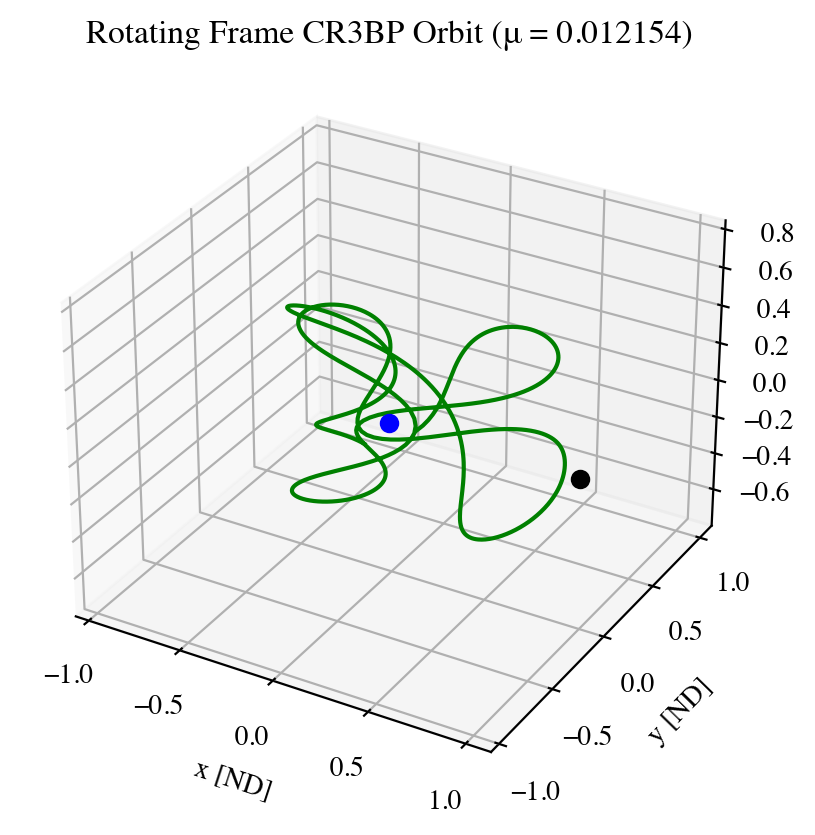

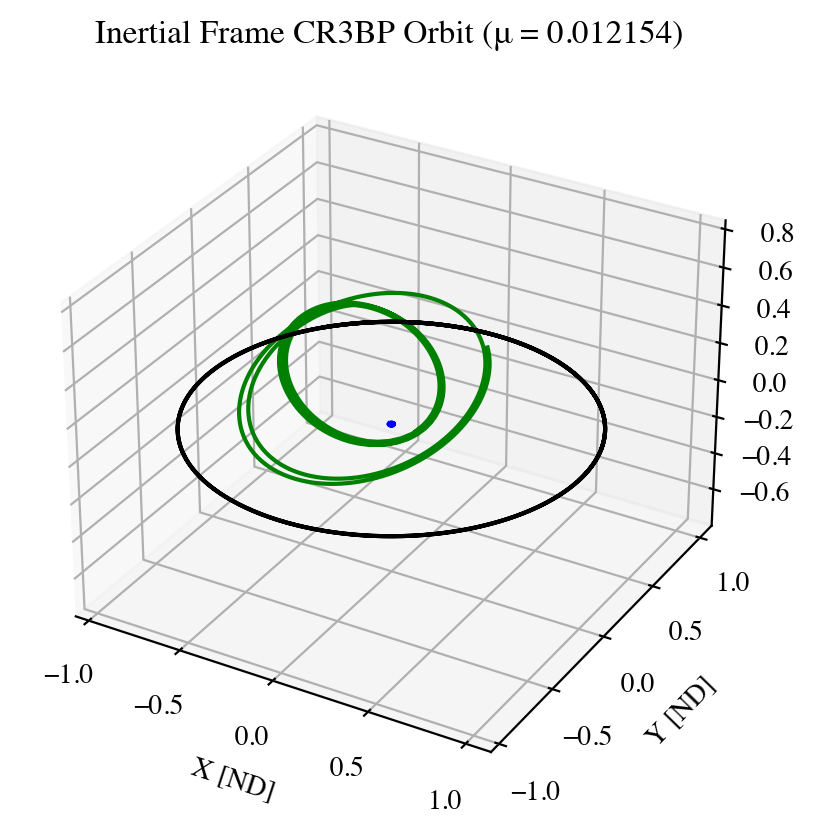

In [420]:
# Rotating Frame Plot
fig = plt.figure()
ax = plt.axes(projection='3d')

# Adding Figure Title and Labels
ax.set_title('Rotating Frame CR3BP Orbit (\u03BC = ' + str(round(mu, 6)) + ')')
ax.set_xlabel('x [ND]')
ax.set_ylabel('y [ND]')
ax.set_zlabel('z [ND]')

# Plotting Rotating Frame Positions
ax.plot3D(X_rot, Y_rot, Z_rot, c='green')
ax.plot3D(m1_loc[0], m1_loc[1], m1_loc[2], c='blue', marker='o')
ax.plot3D(m2_loc[0], m2_loc[1], m2_loc[2], c='black', marker='o')

# Setting Axis Limits
xyzlim = np.array([ax.get_xlim3d(), ax.get_ylim3d(), ax.get_zlim3d()]).T
XYZlim = np.asarray([min(xyzlim[0]), max(xyzlim[1])])
ax.set_xlim3d(XYZlim)
ax.set_ylim3d(XYZlim)
ax.set_zlim3d(XYZlim * 3 / 4)


# Inertial Frame Plot
fig = plt.figure()
ax = plt.axes(projection='3d')

# Adding Figure Title and Labels
ax.set_title('Inertial Frame CR3BP Orbit (\u03BC = ' + str(round(mu, 6)) + ')')
ax.set_xlabel('X [ND]')
ax.set_ylabel('Y [ND]')
ax.set_zlabel('Z [ND]')

# Plotting Inertial Frame Positions
ax.plot3D(X_Iner, Y_Iner, Z_Iner, c='green')
ax.plot3D(X_m1, Y_m1, Z_m1, c='blue')
ax.plot3D(X_m2, Y_m2, Z_m2, c='black')

# Setting Axis Limits
ax.set_xlim3d(XYZlim)
ax.set_ylim3d(XYZlim)
ax.set_zlim3d(XYZlim * 3 / 4)

plt.show()


RuntimeError: Requested MovieWriter (PillowWriter) not available

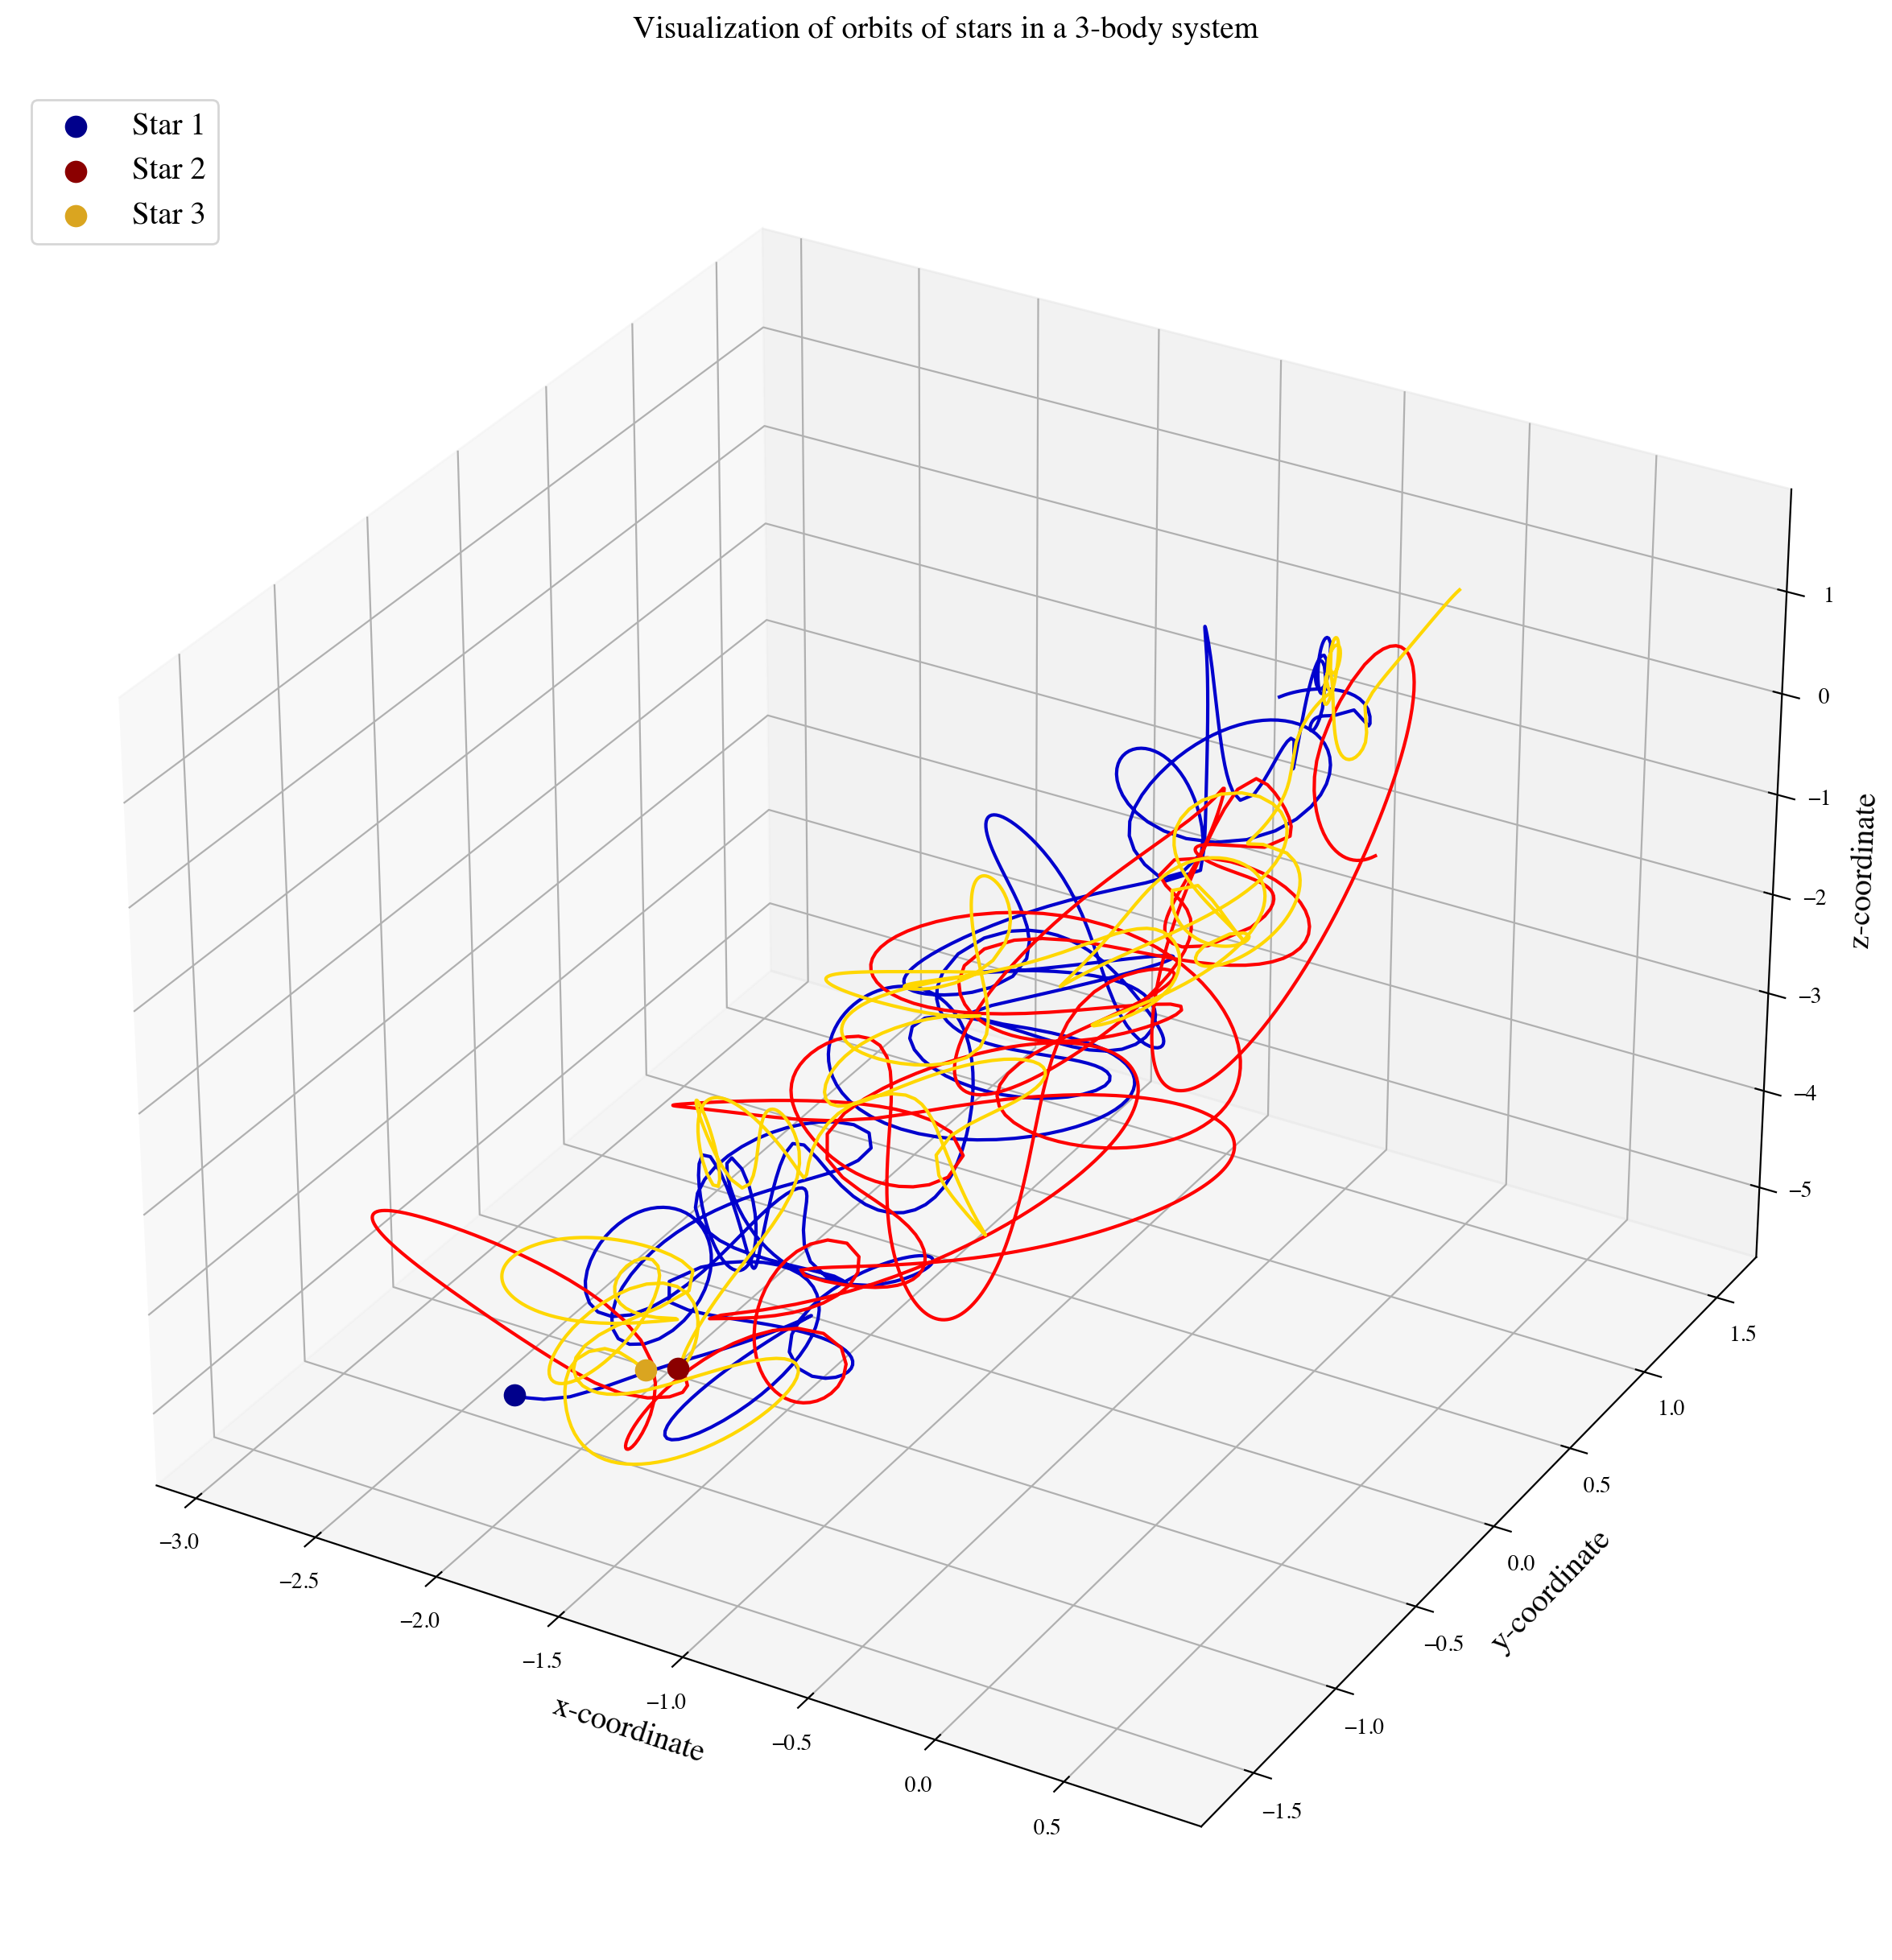

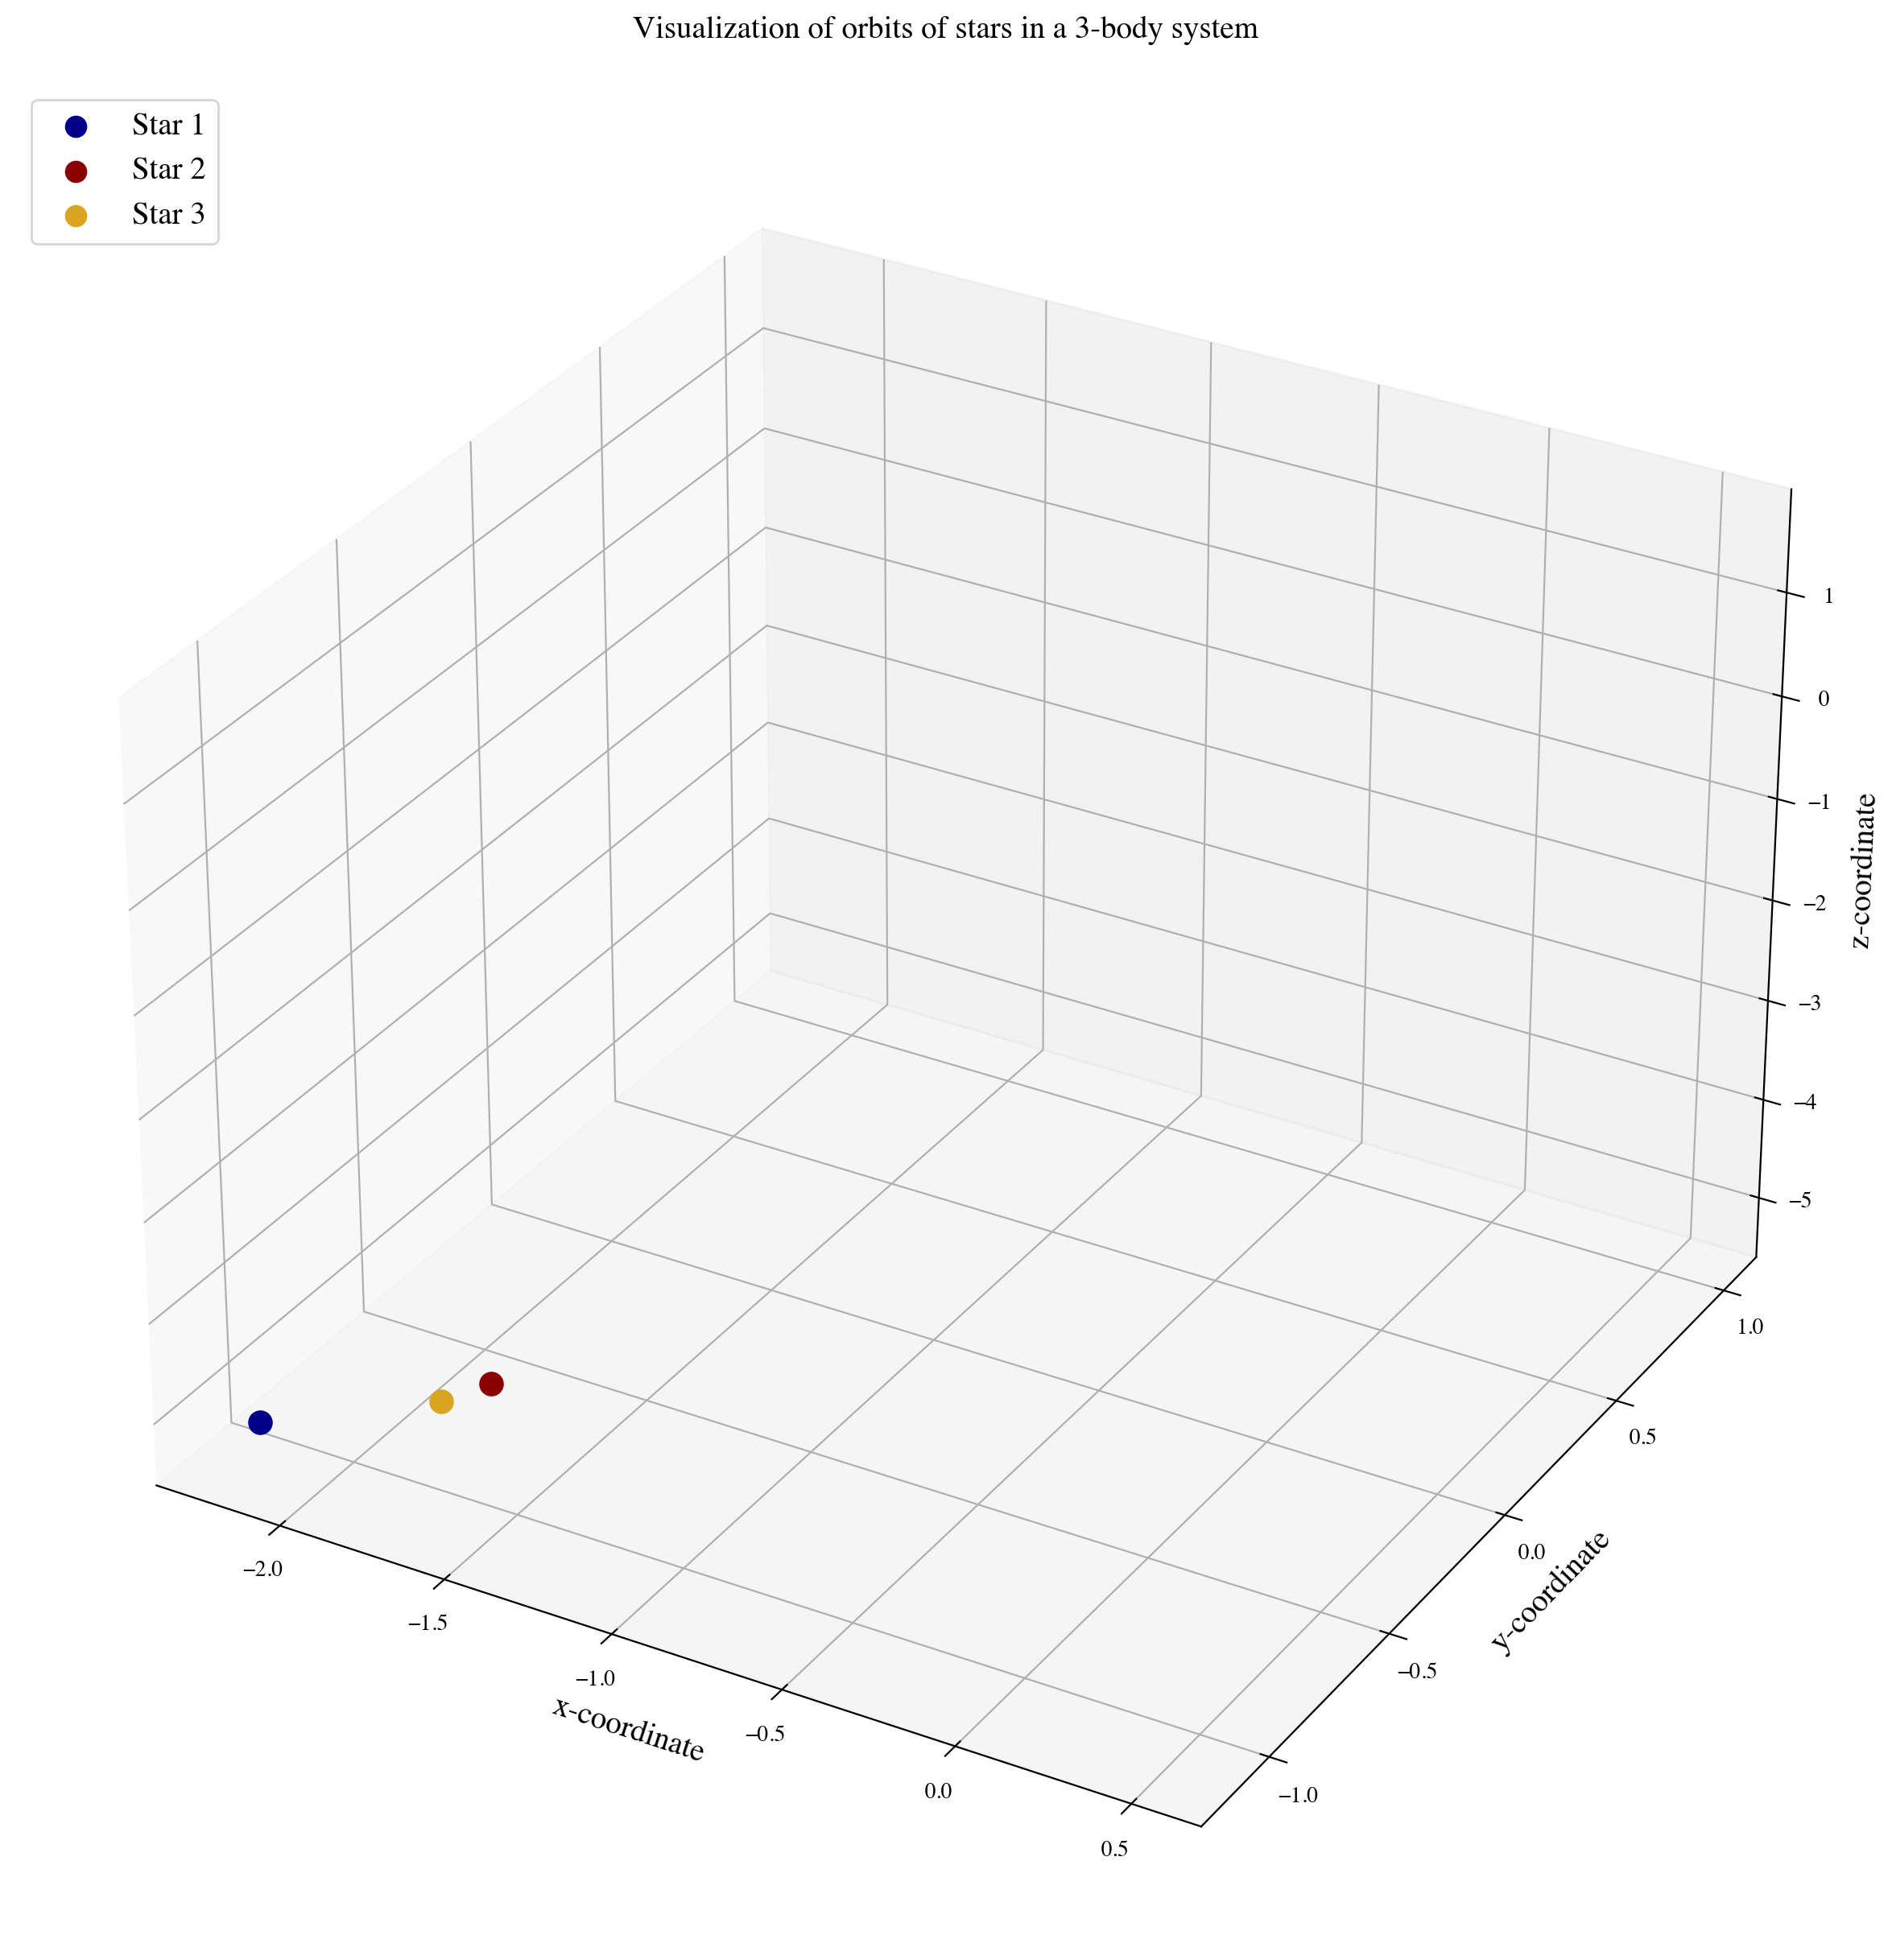

In [436]:


#Importing important libraries

import scipy as sci
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

plt.rcParams['animation.ffmpeg_path'] = '/usr/local/bin/ffmpeg'

# Non-Dimensionalisation

G=6.67408e-11 #N-m2/kg2

#Reference quantities
m_nd=1.989e+30 #kg
r_nd=5.326e+12 #m
v_nd=30000 #m/s
t_nd=79.91*365.25*24*3600 #s

#Net constants
K1=G*t_nd*m_nd/(r_nd**2*v_nd)
K2=v_nd*t_nd/r_nd

#Define masses
m1=1.1 #Star 1
m2=0.907 #Star 2
m3=1.425 #Star 3


#Define initial position vectors
r1=[-0.5,1,0] #m
r2=[0.5,0,0.5] #m
r3=[0.2,1,1.5] #m

#Convert pos vectors to arrays
r1=np.array(r1)
r2=np.array(r2)
r3=np.array(r3)

#Find Centre of Mass
r_com=(m1*r1+m2*r2+m3*r3)/(m1+m2+m3)

#Define initial velocities
v1=[0.02,0.02,0.02] #m/s
v2=[-0.05,0,-0.1] #m/s
v3=[0,-0.03,0]

#Convert velocity vectors to arrays
v1=np.array(v1)
v2=np.array(v2)
v3=np.array(v3)

#Find velocity of COM
v_com=(m1*v1+m2*v2+m3*v3)/(m1+m2+m3)


def ThreeBodyEquations(w,t,G,m1,m2):
    #Unpack all the variables from the array "w"
    r1=w[:3]
    r2=w[3:6]
    r3=w[6:9]
    v1=w[9:12]
    v2=w[12:15]
    v3=w[15:18]
    
    #Find out distances between the three bodies
    r12=sci.linalg.norm(r2-r1)
    r13=sci.linalg.norm(r3-r1)
    r23=sci.linalg.norm(r3-r2)
    
    #Define the derivatives according to the equations
    dv1bydt=K1*m2*(r2-r1)/r12**3+K1*m3*(r3-r1)/r13**3
    dv2bydt=K1*m1*(r1-r2)/r12**3+K1*m3*(r3-r2)/r23**3
    dv3bydt=K1*m1*(r1-r3)/r13**3+K1*m2*(r2-r3)/r23**3
    dr1bydt=K2*v1
    dr2bydt=K2*v2
    dr3bydt=K2*v3
    
    #Package the derivatives into one final size-18 array
    r12_derivs=np.concatenate((dr1bydt,dr2bydt))
    r_derivs=np.concatenate((r12_derivs,dr3bydt))
    v12_derivs=np.concatenate((dv1bydt,dv2bydt))
    v_derivs=np.concatenate((v12_derivs,dv3bydt))
    derivs=np.concatenate((r_derivs,v_derivs))
    return derivs


#Package initial parameters
init_params=np.array([r1,r2,r3,v1,v2,v3]) #Package initial parameters into one size-18 array
init_params=init_params.flatten() #Flatten the array to make it 1D
time_span=np.linspace(0,20,1000) #Time span is 20 orbital years and 1000 points


#Run the ODE solver
import scipy.integrate
three_body_sol=sci.integrate.odeint(ThreeBodyEquations,init_params,time_span,args=(G,m1,m2))


#Store the position solutions into three distinct arrays
r1_sol=three_body_sol[:,:3]
r2_sol=three_body_sol[:,3:6]
r3_sol=three_body_sol[:,6:9]


#Plot the orbits of the three bodies
fig=plt.figure(figsize=(15,15))
ax=fig.add_subplot(111,projection="3d")
ax.plot(r1_sol[:,0],r1_sol[:,1],r1_sol[:,2],color="mediumblue")
ax.plot(r2_sol[:,0],r2_sol[:,1],r2_sol[:,2],color="red")
ax.plot(r3_sol[:,0],r3_sol[:,1],r3_sol[:,2],color="gold")
ax.scatter(r1_sol[-1,0],r1_sol[-1,1],r1_sol[-1,2],color="darkblue",marker="o",s=80,label="Star 1")
ax.scatter(r2_sol[-1,0],r2_sol[-1,1],r2_sol[-1,2],color="darkred",marker="o",s=80,label="Star 2")
ax.scatter(r3_sol[-1,0],r3_sol[-1,1],r3_sol[-1,2],color="goldenrod",marker="o",s=80,label="Star 3")
ax.set_xlabel("x-coordinate",fontsize=14)
ax.set_ylabel("y-coordinate",fontsize=14)
ax.set_zlabel("z-coordinate",fontsize=14)
ax.set_title("Visualization of orbits of stars in a 3-body system\n",fontsize=14)
ax.legend(loc="upper left",fontsize=14)


#Animate the orbits of the three bodies


#Make the figure 
fig=plt.figure(figsize=(15,15))
ax=fig.add_subplot(111,projection="3d")

#Create new arrays for animation, this gives you the flexibility
#to reduce the number of points in the animation if it becomes slow
#Currently set to select every 4th point
r1_sol_anim=r1_sol[::1,:].copy()
r2_sol_anim=r2_sol[::1,:].copy()
r3_sol_anim=r3_sol[::1,:].copy()

#Set initial marker for planets, that is, blue,red and green circles at the initial positions
head1=[ax.scatter(r1_sol_anim[0,0],r1_sol_anim[0,1],r1_sol_anim[0,2],color="darkblue",marker="o",s=80,label="Star 1")]
head2=[ax.scatter(r2_sol_anim[0,0],r2_sol_anim[0,1],r2_sol_anim[0,2],color="darkred",marker="o",s=80,label="Star 2")]
head3=[ax.scatter(r3_sol_anim[0,0],r3_sol_anim[0,1],r3_sol_anim[0,2],color="goldenrod",marker="o",s=80,label="Star 3")]

#Create a function Animate that changes plots every frame (here "i" is the frame number)
def Animate(i,head1,head2,head3):
    #Remove old markers
    head1[0].remove()
    head2[0].remove()
    head3[0].remove()
    
    #Plot the orbits (every iteration we plot from initial position to the current position)
    trace1=ax.plot(r1_sol_anim[:i,0],r1_sol_anim[:i,1],r1_sol_anim[:i,2],color="mediumblue")
    trace2=ax.plot(r2_sol_anim[:i,0],r2_sol_anim[:i,1],r2_sol_anim[:i,2],color="red")
    trace3=ax.plot(r3_sol_anim[:i,0],r3_sol_anim[:i,1],r3_sol_anim[:i,2],color="gold")
    
    #Plot the current markers
    head1[0]=ax.scatter(r1_sol_anim[i-1,0],r1_sol_anim[i-1,1],r1_sol_anim[i-1,2],color="darkblue",marker="o",s=100)
    head2[0]=ax.scatter(r2_sol_anim[i-1,0],r2_sol_anim[i-1,1],r2_sol_anim[i-1,2],color="darkred",marker="o",s=100)
    head3[0]=ax.scatter(r3_sol_anim[i-1,0],r3_sol_anim[i-1,1],r3_sol_anim[i-1,2],color="goldenrod",marker="o",s=100)
    
    return trace1,trace2,trace3,head1,head2,head3,

#Some beautifying
ax.set_xlabel("x-coordinate",fontsize=14)
ax.set_ylabel("y-coordinate",fontsize=14)
ax.set_zlabel("z-coordinate",fontsize=14)
ax.set_title("Visualization of orbits of stars in a 3-body system\n",fontsize=14)
ax.legend(loc="upper left",fontsize=14)


#If used in Jupyter Notebook, animation will not display only a static image will display with this command
# anim_2b = animation.FuncAnimation(fig,Animate_2b,frames=1000,interval=5,repeat=False,blit=False,fargs=(h1,h2))


#Use the FuncAnimation module to make the animation
repeatanim=animation.FuncAnimation(fig,Animate,frames=800,interval=10,repeat=False,blit=False,fargs=(head1,head2,head3))

# Set up formatting for the movie files
Writer = animation.FFMpegWriter['PillowWriter']
writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=4000)

#To save animation to disk, enable this command
# repeatanim.save("ThreeBodyProblem.gif", writer=writer)
repeatanim.save('/Users/bijan1339/Desktop/Research/Figures/the_movie.mp4', writer = 'ffmpeg', fps=15)


In [458]:
import datetime

a = datetime.datetime.today()
numdays = 100
dateList = []
for x in range (0, numdays):
    dateList.append(a - datetime.timedelta(days = x))
print(dateList)


AttributeError: 'list' object has no attribute 'time'

In [449]:
x = [1,2,3,4,5]
y = [x,x,x,x]
y

[[1, 2, 3, 4, 5], [1, 2, 3, 4, 5], [1, 2, 3, 4, 5], [1, 2, 3, 4, 5]]

In [450]:
for arr in y:
    for i in arr:
        arr[2]=7

In [451]:
y

[[1, 2, 7, 4, 5], [1, 2, 7, 4, 5], [1, 2, 7, 4, 5], [1, 2, 7, 4, 5]]